# Regression

## Objectives

*   Fit and evaluate a regression model to predict tenure levels for a prospect that will likely churn


## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict tenure
* labels map
* Feature Importance Plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/churnometer/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/churnometer'

---

# Load Data

In [5]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv")
      .query("Churn == 1")  # subset churned customer
      .drop(labels=['customerID', 'TotalCharges', 'Churn'], axis=1)
      # variables we will not need for this project
      # we will not need Churn since it has only 1
      )

print(df.shape)
df.head(3)


(1869, 18)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65


# MP Pipeline: Regressor

## Create ML pipeline

In [6]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['gender', 'Partner', 'Dependents', 'PhoneService',
                                                                'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                                                'StreamingTV', 'StreamingMovies', 'Contract',
                                                                'PaperlessBilling', 'PaymentMethod'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


Custom Class for hyperparameter optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['tenure'], axis=1),
    df['tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1495, 17) (1495,) 
* Test set: (374, 17) (374,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [9]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.385385,0.457376,0.501618,0.041972
0,LinearRegression,0.324122,0.413173,0.536518,0.071425
4,AdaBoostRegressor,0.322508,0.372907,0.401836,0.027522
6,XGBRegressor,0.285599,0.357254,0.418154,0.054415
2,RandomForestRegressor,0.209381,0.259286,0.362726,0.054991
3,ExtraTreesRegressor,0.108102,0.182182,0.344207,0.085612
1,DecisionTreeRegressor,-0.012792,0.053884,0.204671,0.07931


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [12]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may consider more hyperparameters and spend more time in this step

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV

In [13]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Check results

In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
7,GradientBoostingRegressor,0.390516,0.460378,0.494202,0.037475,0.01,3,300
0,GradientBoostingRegressor,0.385385,0.457376,0.501618,0.041972,0.1,3,100
1,GradientBoostingRegressor,0.334573,0.393579,0.46182,0.045826,0.1,3,300
6,GradientBoostingRegressor,0.309305,0.375909,0.411159,0.035723,0.01,3,100
8,GradientBoostingRegressor,0.325521,0.364243,0.402208,0.028362,0.01,10,100
9,GradientBoostingRegressor,0.275031,0.335211,0.414007,0.045572,0.01,10,300
10,GradientBoostingRegressor,0.214106,0.259966,0.312236,0.036546,0.01,None,100
2,GradientBoostingRegressor,0.174805,0.222776,0.323823,0.052504,0.1,10,100
15,GradientBoostingRegressor,0.19118,0.209879,0.225179,0.011181,0.001,10,300
17,GradientBoostingRegressor,0.173406,0.192985,0.204097,0.010937,0.001,None,300


Check the best model

In [15]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [16]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 300}

Define the best regressor, based on search

In [17]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=300,
                                           random_state=0))])

## Assess feature importance

* These are the 3 most important features in descending order. The model was trained on them: 
['MonthlyCharges', 'Contract', 'Partner']


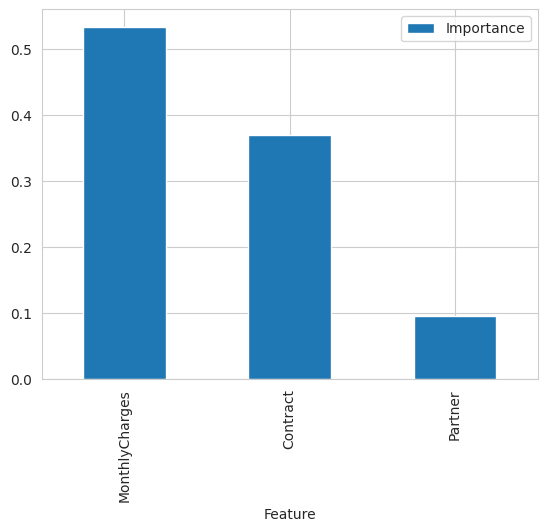

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

In [20]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Model Evaluation 

* Train Set


AttributeError: 'float' object has no attribute 'round'

# Regressor with PCA

Let's explore potential values for PCA n_components.

In [ ]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['tenure'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1869, 17) 
 <class 'numpy.ndarray'>


Apply PCA separately to the scaled data

* The 17 components explain 100.0% of the data 



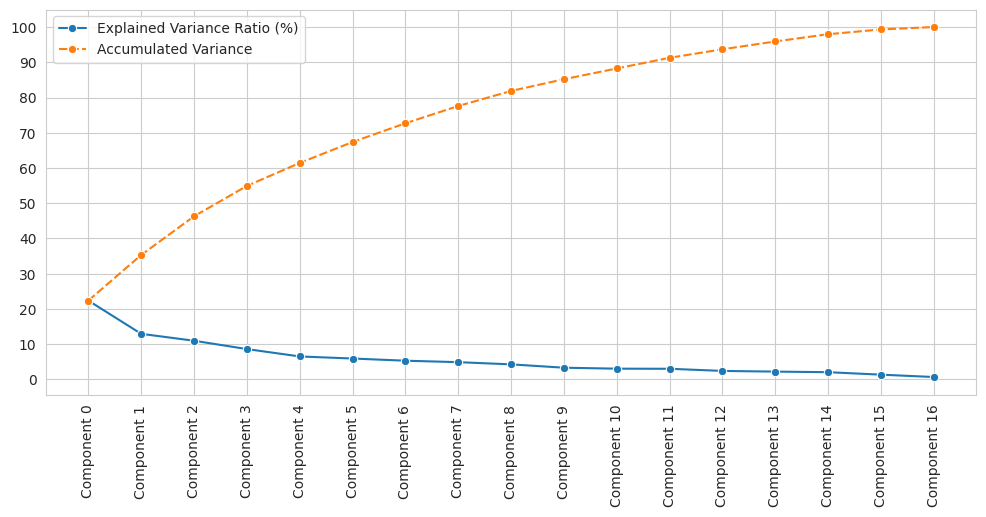

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 7 components explain 72.69% of the data 



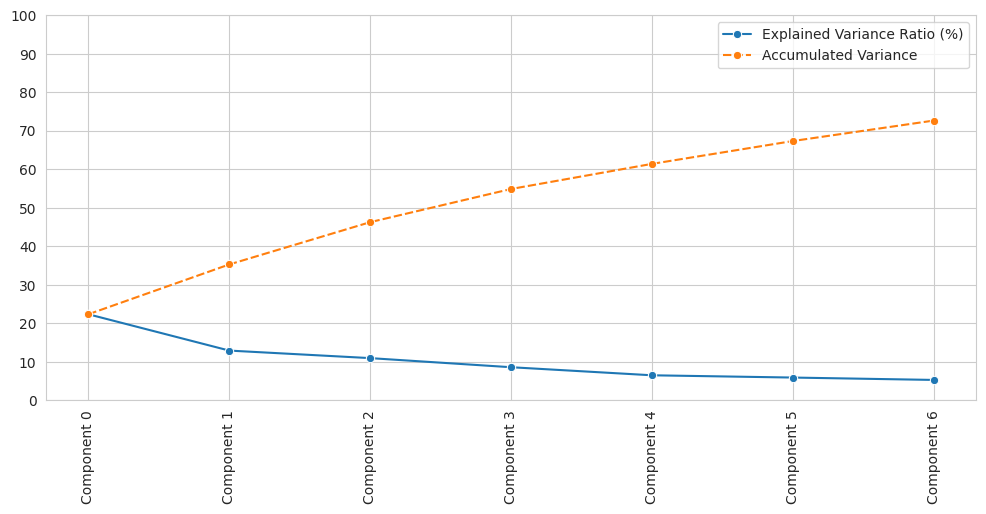

In [ ]:
n_components = 7
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [21]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['gender', 'Partner', 'Dependents', 'PhoneService',
                                                                'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                                                'StreamingTV', 'StreamingMovies', 'Contract',
                                                                'PaperlessBilling', 'PaymentMethod'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


## Grid Search CV – Sklearn

In [22]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1495, 17) (1495,) 
* Test set: (374, 17) (374,)


### Use standard hyperparameters to find the most suitable model.

In [23]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optimisation search 

In [24]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [25]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.444804,0.4773,0.510266,0.021515
0,LinearRegression,0.355961,0.423116,0.49016,0.046042
2,RandomForestRegressor,0.38957,0.41981,0.456919,0.026936
3,ExtraTreesRegressor,0.327463,0.373074,0.413739,0.030707
6,XGBRegressor,0.303374,0.355202,0.415623,0.038104
4,AdaBoostRegressor,0.209676,0.27327,0.360507,0.048892
1,DecisionTreeRegressor,-0.088684,0.018346,0.155102,0.083129


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [26]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10, None],
    }
}

Extensive GridSearch CV

In [27]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Check results

In [28]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
0,GradientBoostingRegressor,0.444804,0.4773,0.510266,0.021515,0.1,3,100
7,GradientBoostingRegressor,0.426488,0.466559,0.497141,0.02573,0.01,3,300
1,GradientBoostingRegressor,0.423589,0.447267,0.482018,0.025103,0.1,3,300
9,GradientBoostingRegressor,0.326951,0.378068,0.430111,0.040984,0.01,10,300
8,GradientBoostingRegressor,0.313756,0.366371,0.412733,0.035917,0.01,10,100
6,GradientBoostingRegressor,0.311333,0.341241,0.370785,0.020809,0.01,3,100
2,GradientBoostingRegressor,0.26127,0.336601,0.408484,0.051693,0.1,10,100
3,GradientBoostingRegressor,0.240303,0.320649,0.393707,0.052732,0.1,10,300
10,GradientBoostingRegressor,0.204823,0.264881,0.350077,0.055546,0.01,None,100
15,GradientBoostingRegressor,0.177184,0.205792,0.231306,0.020528,0.001,10,300


Check the best model

In [29]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [30]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

Define the best regressor

In [31]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model', GradientBoostingRegressor(random_state=0))])

## Evaluate Regressor on Train and Tests Sets

In [32]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

Model Evaluation 

* Train Set


AttributeError: 'float' object has no attribute 'round'

# Convert Regression to Classification

### Convert numerical target to bins, and check if it is balanced

* The classes represent the following ranges: 
{'tenure': [-inf, 4.0, 20.0, inf]} 



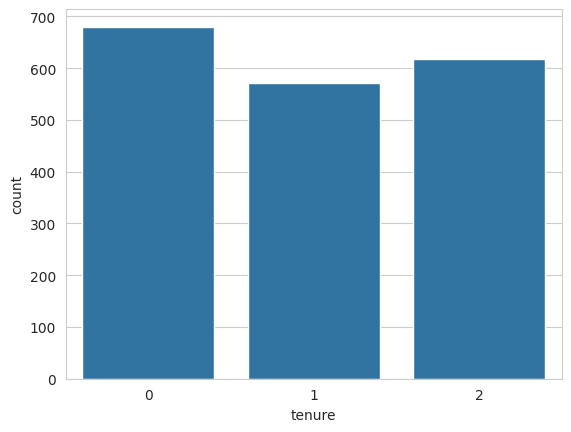

In [66]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=3, variables=['tenure'])  # we will try q as 2, and 3
df_clf = disc.fit_transform(df)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='tenure')
plt.show()

In [67]:
df_clf.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
2,Male,0,No,No,0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
4,Female,0,No,No,0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70
5,Female,0,No,No,1,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65


## Rewrite ML Pipeline for Modelling

In [68]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['gender', 'Partner', 'Dependents', 'PhoneService',
                                                                'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                                                'StreamingTV', 'StreamingMovies', 'Contract',
                                                                'PaperlessBilling', 'PaymentMethod'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


## Load algorithms for classification

In [69]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

## Split Train Test Sets

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['tenure'], axis=1),
    df_clf['tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1495, 17) (1495,) 
* Test set: (374, 17) (374,)


## Grid Seach CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [71]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [72]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

Check results

In [73]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,AdaBoostClassifier,0.71028,0.74306,0.785047,0.025691
3,GradientBoostingClassifier,0.672897,0.705781,0.766355,0.037031
0,XGBClassifier,0.537037,0.687331,0.88785,0.11918
1,DecisionTreeClassifier,0.551402,0.607061,0.700935,0.053403
4,ExtraTreesClassifier,0.514019,0.577224,0.64486,0.04534
2,RandomForestClassifier,0.504673,0.560471,0.64486,0.052707


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define models and parameters

In [64]:
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search = {
    "AdaBoostClassifier": {
        'model__n_estimators': [50, 100, 300],
        'model__learning_rate': [1e-1, 1e-2, 1e-3],
    }
}


Extensive GridSearch CV

In [42]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)



Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

Check results

In [43]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
6,AdaBoostClassifier,0.757009,0.87712,0.971963,0.076554,0.001,50
7,AdaBoostClassifier,0.757009,0.867861,0.971963,0.073967,0.001,100
8,AdaBoostClassifier,0.757009,0.826739,0.87037,0.039713,0.001,300
3,AdaBoostClassifier,0.757009,0.796971,0.814815,0.020399,0.01,50
4,AdaBoostClassifier,0.757009,0.795102,0.814815,0.02012,0.01,100
5,AdaBoostClassifier,0.757009,0.783956,0.805556,0.018387,0.01,300
0,AdaBoostClassifier,0.757009,0.770976,0.803738,0.01693,0.1,50
1,AdaBoostClassifier,0.728972,0.763499,0.803738,0.024069,0.1,100
2,AdaBoostClassifier,0.703704,0.741243,0.785047,0.027649,0.1,300



Check the best model

In [44]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Parameters for best model
* We are saving this content for later

In [45]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.001, 'model__n_estimators': 50}

Define the best clf pipeline

In [46]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(learning_rate=0.001, random_state=0))])

## Assess feature importance

We can assess feature importance for this model with `.feature_importances_`

* These are the 3 most important features in descending order. The model was trained on them: 
['MonthlyCharges', 'Contract', 'PaymentMethod']


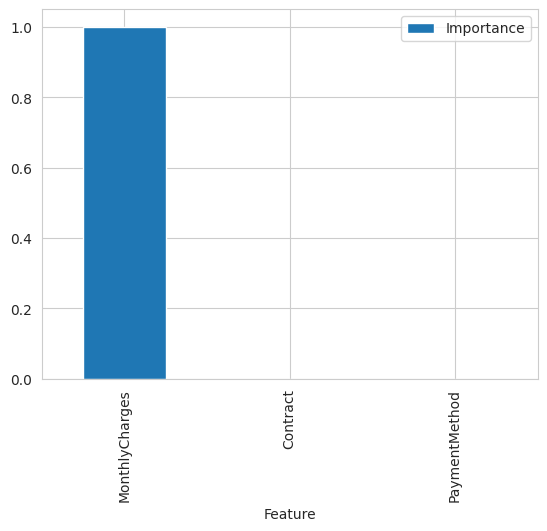

In [47]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

Custom Function

In [48]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


List that relates the classes and tenure interval

In [49]:
disc.binner_dict_['tenure']

[-inf, 4.0, 20.0, inf]

We can create manually

In [50]:
label_map = ['<4.0', '4.0 to 20.0','+20.0']
label_map

['<4.0', '4.0 to 20.0', '+20.0']

In [51]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                       Actual <4.0 Actual 4.0 to 20.0 Actual +20.0
Prediction <4.0                432                234          157
Prediction 4.0 to 20.0           5                 11            4
Prediction +20.0               100                222          330


---  Classification Report  ---
              precision    recall  f1-score   support

        <4.0       0.52      0.80      0.64       537
 4.0 to 20.0       0.55      0.02      0.05       467
       +20.0       0.51      0.67      0.58       491

    accuracy                           0.52      1495
   macro avg       0.53      0.50      0.42      1495
weighted avg       0.53      0.52      0.43      1495
 

#### Test Set ####

---  Confusion Matrix  ---
                       Actual <4.0 Actual 4.0 to 20.0 Actual +20.0
Prediction <4.0                115                 48           34
Prediction 4.0 to 20.0           2                  1            0
Prediction +20.0  

# Which pipeline to choose?

We fitted 3 pipelines:
* Regression
* Regression with PCA
* Classifier

The regressor pipelines didn't reach the expected performance threshold (0.7 R2 score) for the train and test set.

The classifier was tuned on Recall for class 0 (tenure <4 months), since we are interested to detect prospects that may churn soon. 
* It has reasonable performance for class 0 (<4 months) and class 2 (+20 months)
* Class 1 (4 to 20 months) has weak performance.

In [52]:
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(learning_rate=0.001, random_state=0))])

# Refit pipeline with best features

## Rewrite Pipeline

In [53]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Contract', 'PaymentMethod'])),

        ("feat_scaling", StandardScaler()),

        # feature selection is not needed

        ("model", model),

    ])

    return pipeline_base


## Split Train Test Set, only with best features

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['tenure'], axis=1),
    df_clf['tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1495, 17) (1495,) 
* Test set: (374, 17) (374,)


Subset Best Features

In [55]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1495, 3) (1495,) 
* Test set: (374, 3) (374,)


,MonthlyCharges,Contract,PaymentMethod
5779,95.55,One year,Electronic check
2608,34.50,Month-to-month,Electronic check
2464,77.15,Month-to-month,Electronic check


## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [74]:
models_search

{'AdaBoostClassifier': AdaBoostClassifier(random_state=0)}

And the best parameters from the previous GridCV search

In [75]:
best_parameters

{'model__learning_rate': 0.001, 'model__n_estimators': 50}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [76]:
params_search = {'AdaBoostClassifier':  {
    'model__learning_rate': [0.001],   # the value should be in []
    'model__n_estimators': [50]       # the value should be in []
}
}
params_search

{'AdaBoostClassifier': {'model__learning_rate': [0.001],
  'model__n_estimators': [50]}}

GridSearch CV

In [77]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa


Check results

In [78]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
0,AdaBoostClassifier,0.757009,0.87712,0.971963,0.076554,0.001,50


Check the best model

In [79]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Define the best clf pipeline

In [80]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(learning_rate=0.001, random_state=0))])

## Assess feature importance

In [81]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


ValueError: All arrays must be of the same length

## Evaluate Classifier on Train and Test Sets

In [82]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                       Actual <4.0 Actual 4.0 to 20.0 Actual +20.0
Prediction <4.0                432                234          157
Prediction 4.0 to 20.0           5                 11            4
Prediction +20.0               100                222          330


---  Classification Report  ---
              precision    recall  f1-score   support

        <4.0       0.52      0.80      0.64       537
 4.0 to 20.0       0.55      0.02      0.05       467
       +20.0       0.51      0.67      0.58       491

    accuracy                           0.52      1495
   macro avg       0.53      0.50      0.42      1495
weighted avg       0.53      0.52      0.43      1495
 

#### Test Set ####

---  Confusion Matrix  ---
                       Actual <4.0 Actual 4.0 to 20.0 Actual +20.0
Prediction <4.0                115                 48           34
Prediction 4.0 to 20.0           2                  1            0
Prediction +20.0  

# Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [83]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_tenure/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [84]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
5779,Female,0,No,No,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,No,One year,Yes,Electronic check,95.55
2608,Male,0,Yes,Yes,No,No phone service,DSL,Yes,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,34.50
2464,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,77.15
4149,Male,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,Yes,Yes,Two year,No,Electronic check,49.35
6612,Male,0,Yes,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,69.90


In [85]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [86]:
y_train

5779    2
2608    1
2464    0
4149    2
6612    0
       ..
3188    1
4651    1
6256    0
2101    2
2631    1
Name: tenure, Length: 1495, dtype: int64

In [87]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [88]:
X_test.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
2900,Female,1,Yes,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.25
996,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),70.00
4005,Male,0,No,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,24.05
334,Female,0,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,80.60
6341,Female,0,No,No,Yes,Yes,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,100.35


In [89]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [90]:
y_test

2900    0
996     2
4005    0
334     0
6341    1
       ..
2570    2
2527    1
5186    0
5198    2
710     0
Name: tenure, Length: 374, dtype: int64

In [91]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

ML pipeline for predicting tenure

In [92]:
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(learning_rate=0.001, random_state=0))])

In [93]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

['outputs/ml_pipeline/predict_tenure/v1/clf_pipeline.pkl']

## List  mapping target levels to ranges

Map for converting numerical variable to categorical variable

In [94]:
label_map

['<4.0', '4.0 to 20.0', '+20.0']

In [95]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

['outputs/ml_pipeline/predict_tenure/v1/label_map.pkl']

## Feature importance plot

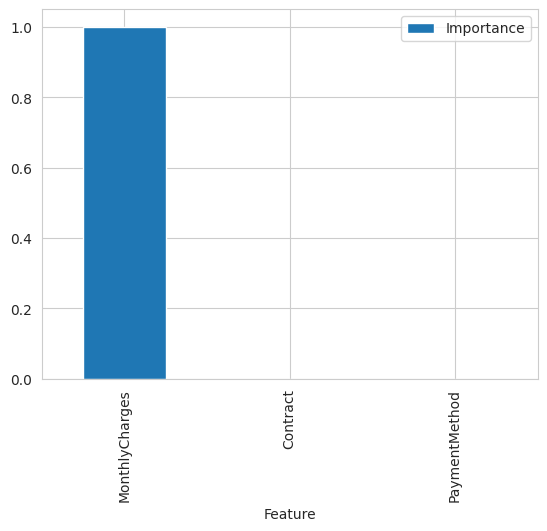

In [96]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

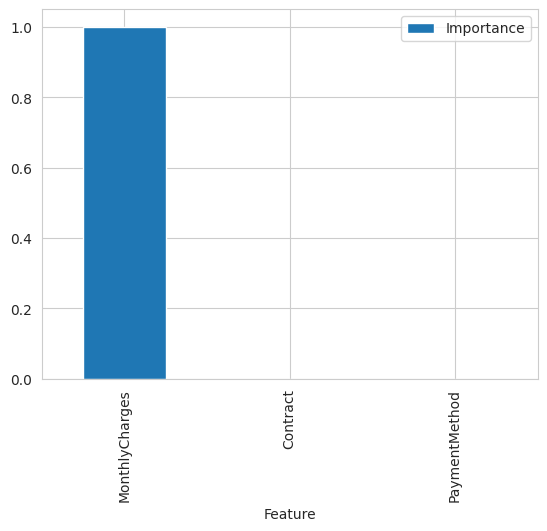

In [97]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job! Clear cell's outputs, push to the repo using git commands and move on to the next notebook

---